In [ ]:
#!pip list > requirment.txt

In [ ]:
#!unzip "/content/drive/MyDrive/2021_iraosuhas/seg_train.zip" -d "/content/drive/MyDrive/2021_iraosuhas"
#!unzip "/content/drive/MyDrive/2021_iraosuhas/seg_test.zip" -d "/content/drive/MyDrive/2021_iraosuhas"
#!unzip "/content/drive/MyDrive/2021_iraosuhas/seg_pred.zip" -d "/content/drive/MyDrive/2021_iraosuhas"

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
os.chdir('/content/drive/MyDrive/2021_iraosuhas')
import glob
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers

import tensorflow as tf
from model_files.utils import get_the_classes
from model_files.model import create_model
np.random.seed(123)

In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [9]:
##Get the trainning data
train_path = '/content/drive/MyDrive/2021_iraosuhas/seg_train'
class_dict, classes = get_the_classes(train_path)
print(classes) 
print(class_dict)

number_of_classes 6
['mountain', 'glacier', 'sea', 'street', 'forest', 'buildings']
{'mountain': 0, 'glacier': 1, 'sea': 2, 'street': 3, 'forest': 4, 'buildings': 5}


In [29]:
##Building the train data frame:
#Get the list of the files and classes
image_file_name = glob.glob('**/**')
class_for_file = [ file.split('/')[0] for file in image_file_name]

#create the data frame
image_data_train =  pd.DataFrame({'filename':image_file_name, 'classes': class_for_file})
image_data_train = shuffle(image_data_train)
image_data_train = image_data_train.reset_index(drop=True)

image_data_train['classes'] = image_data_train['classes'].map(class_dict)

##Get the trainning data
print('Train sample: ', len(image_data_train['classes']), dict(image_data_train['classes'].value_counts()))

##------------------------------------------------------------------------

##Get the test data
test_path = '/content/drive/MyDrive/2021_iraosuhas/seg_test'
test_class_dict, test_classes = get_the_classes(test_path)

##Building the test data frame:
#Get the list of the files and classes
os.chdir(test_path)
image_file_name = glob.glob('**/**')
class_for_file = [ file.split('/')[0] for file in image_file_name]

#create the data frame
image_data_test =  pd.DataFrame({'filename':image_file_name, 'classes': class_for_file})
image_data_test = shuffle(image_data_test)
image_data_test = image_data_test.reset_index(drop=True)

image_data_test['classes'] = image_data_test['classes'].map(class_dict)
print('Test sample: ', len(image_data_test['classes']), dict(image_data_test['classes'].value_counts()))

Train sample:  3000 {1: 553, 0: 525, 2: 510, 3: 501, 4: 474, 5: 437}
number_of_classes 6
Test sample:  3000 {1: 553, 0: 525, 2: 510, 3: 501, 4: 474, 5: 437}


In [45]:
image_data_train.head(6)

,filename,classes
0,mountain/22712.jpg,0
1,sea/21740.jpg,2
2,buildings/23776.jpg,5
3,glacier/24133.jpg,1
4,sea/22730.jpg,2
5,buildings/22284.jpg,5


In [26]:
print(image_data_train.shape)

(14034, 2)


In [31]:
## Spliting the test to have the validation set as the training data set is already having less images.
data_test, data_val  = train_test_split(image_data_test, test_size=0.5, random_state=42, stratify=image_data_test['classes'])

print('Spliting into test and val, 50%')
print('Test sample: ', len(data_test['classes']), dict(data_test['classes'].value_counts()))
print('Val  sample: ', len(data_val['classes']), dict(data_val['classes'].value_counts()))

Spliting into test and val, 50%
Test sample:  1500 {1: 276, 0: 263, 2: 255, 3: 251, 4: 237, 5: 218}
Val  sample:  1500 {1: 277, 0: 262, 2: 255, 3: 250, 4: 237, 5: 219}


In [32]:
data_test.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

In [ ]:
##Get the prediction data, unlabeled
pred_path = '/content/drive/MyDrive/2021_iraosuhas/seg_pred'
filename = glob.glob('*')
image_data_pred = pd.DataFrame({'filename':filename})
print(len(image_data_pred))
#print('Pred sample: ', len(image_data_pred['classes']), dict(image_data_pred['classes'].value_counts()))

6


In [40]:
image_data_train['filename'][0]

'mountain/22712.jpg'

In [49]:
# Read the image files and get the images arrays
IMAGE_SIZE = (150,150)
images = []
for im_file in tqdm(image_data_train['filename']):
  #print(im_file)
  image = cv2.imread(im_file)
  image = cv2.resize(image,IMAGE_SIZE)
  images.append(image)

images_train = np.array(images)
labels_train = image_data_train['classes'].value
print(images.shape)
print(input_labels.shape)

##Store the images file:
np.save('/content/drive/MyDrive/2021_iraosuhas/model_files/images_train.npy', images_train)

100%|██████████| 3000/3000 [19:40<00:00,  2.54it/s]


AttributeError: ignored

In [59]:
# Read the image files and get the images arrays
IMAGE_SIZE = (150,150)
images = []
for im_file in tqdm(data_val['filename']):
  #print(im_file)
  image = cv2.imread(im_file)
  image = cv2.resize(image,IMAGE_SIZE)
  images.append(image)

images_val = np.array(images)
labels_val = data_val['classes'].values
print(images_val.shape)
print(labels_val.shape)

##Store the images file:
np.save('/content/drive/MyDrive/2021_iraosuhas/model_files/images_val.npy', images_val)

100%|██████████| 1500/1500 [00:04<00:00, 313.32it/s]


(1500, 150, 150, 3)
(1500,)


In [73]:
"""os.chdir(train_path)
##Plot the images
f,ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,3,3)
for i in range(0,3,1):
    for j in range(0,3,1):
        rnd_number = np.random.randint(0,len(images))
        ax[i,j].imshow(images[rnd_number])
        ax[i,j].set_title([key for key, val in class_dict.items() if val == class_dict[rnd_number]][0])
        ax[i,j].axis('off')"""

"os.chdir(train_path)\n##Plot the images\nf,ax = plt.subplots(3,3) \nf.subplots_adjust(0,0,3,3)\nfor i in range(0,3,1):\n    for j in range(0,3,1):\n        rnd_number = np.random.randint(0,len(images))\n        ax[i,j].imshow(images[rnd_number])\n        ax[i,j].set_title([key for key, val in class_dict.items() if val == class_dict[rnd_number]][0])\n        ax[i,j].axis('off')"

(<matplotlib.image.AxesImage at 0x7f6d29fc8190>,
 <matplotlib.image.AxesImage at 0x7f6d29fc8590>)

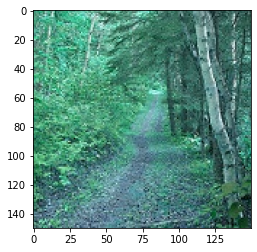

In [74]:
plt.imshow(images[1]), plt.imshow(images[2])

In [86]:
##Build the random model with any set of layers

IMAGE_SIZE = (150,150)
model = create_model(IMAGE_SIZE, classes)
model.summary()

TypeError: ignored

In [81]:
import datetime
init_time = datetime.datetime.now()

BATCH_SIZE = 30
EPOCHS = 5
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)

trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[learning_rate_reduction],
                  )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

NameError: ignored

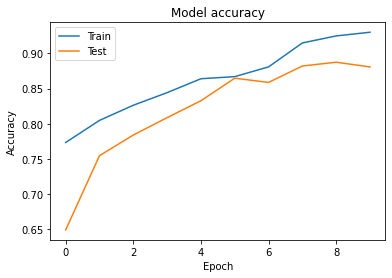

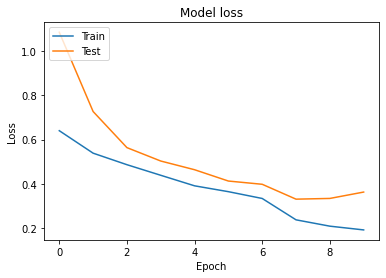

In [ ]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=0)
print('\naccuracy:', val_acc, '  loss: ',val_loss)


accuracy: 0.8806666731834412   loss:  0.3637213110923767


In [ ]:
predict = np.argmax(model.predict(val_images), axis=1)
predict

array([0, 3, 4, ..., 3, 2, 3])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(val_labels, predict))
print(confusion_matrix(val_labels, predict))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       262
           1       0.93      0.81      0.86       277
           2       0.93      0.92      0.92       255
           3       0.97      0.74      0.84       250
           4       0.98      0.97      0.97       237
           5       0.74      0.95      0.83       219

    accuracy                           0.88      1500
   macro avg       0.89      0.88      0.88      1500
weighted avg       0.89      0.88      0.88      1500

[[242  11   5   0   0   4]
 [ 43 223   7   1   1   2]
 [ 10   5 234   0   1   5]
 [  3   0   1 186   1  59]
 [  1   1   2   0 229   4]
 [  3   1   2   4   2 207]]


In [ ]:
IMAGE_SIZE

(150, 150)

In [ ]:
###pretrained model 


    

In [ ]:
model = pre_model()
model.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                            

In [ ]:
init_time = datetime.datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)

BATCH_SIZE = 30
EPOCHS = 10
trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[learning_rate_reduction],
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

Epoch 1/10
468/468 [==============================] - 89s 176ms/step - loss: 0.4133 - accuracy: 0.8533 - val_loss: 0.2679 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 2/10
468/468 [==============================] - 83s 177ms/step - loss: 0.2554 - accuracy: 0.9045 - val_loss: 0.2614 - val_accuracy: 0.9120 - lr: 0.0010
Epoch 3/10
468/468 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9195
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
468/468 [==============================] - 83s 177ms/step - loss: 0.2134 - accuracy: 0.9195 - val_loss: 0.2469 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 4/10
468/468 [==============================] - 83s 177ms/step - loss: 0.1657 - accuracy: 0.9408 - val_loss: 0.2345 - val_accuracy: 0.9133 - lr: 3.0000e-04
Epoch 5/10
468/468 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9442
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
468/468 [==============

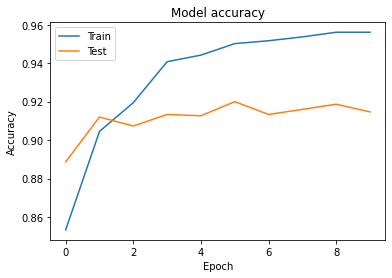

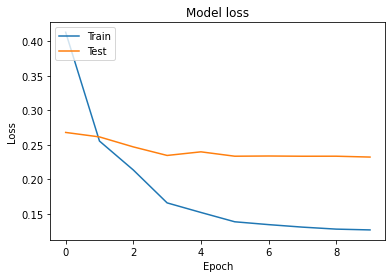

In [ ]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)

predict = np.argmax(model.predict(test_images), axis=1)
predict


accuracy: 0.8966666460037231   loss:  0.2922168970108032


array([3, 4, 3, ..., 3, 4, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(test_labels, predict))
print(confusion_matrix(test_labels, predict))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       263
           1       0.84      0.82      0.83       276
           2       0.92      0.95      0.93       255
           3       0.90      0.93      0.92       251
           4       0.96      0.99      0.97       237
           5       0.91      0.88      0.90       218

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500

[[218  34   8   1   2   0]
 [ 36 226   9   1   2   2]
 [  4   6 241   0   2   2]
 [  0   1   1 234   2  13]
 [  0   2   0   0 234   1]
 [  0   0   2  23   1 192]]


In [ ]:
# save model and architecture to single file
os.chdir('/content/drive/MyDrive/2021_iraosuhas/saved_model')
model.save("model_vgg.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import load_model
#model saved path.
os.chdir('/content/drive/MyDrive/2021_iraosuhas/saved_model')
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

In [ ]:
file = image_data_train['filename'][0]
image = cv2.imread('/content/drive/MyDrive/2021_iraosuhas/seg_pred/10004.jpg')

In [ ]:
image

In [ ]:
BATCH_SIZE = 22
a = image_data_train[ : image_data_train.shape[0] // BATCH_SIZE * BATCH_SIZE]

In [ ]:
a.shape

In [ ]:
image_data_train.shape

In [ ]:
image_data_train.shape[0] // 2 * 2

In [ ]:
image_data_train.shape[0] - 22

In [ ]:
image_data_train.shape